In [2]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2
import pei.laborfunctions as lf
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.cm as cm
from dask.diagnostics import ProgressBar
plt.style.use('/home/aos/kyan/.config/matplotlib/esm2m.mplstyle')

# Plot Baselines

In [34]:
# Open baseline data
ds_base_esm2m = xr.open_dataarray('../data/processed/GFDL/esm2m_baseline_hottestmonths.nc')
ds_base_cesm2 = xr.open_dataarray('../data/processed/CESM2/cesm2_baseline_hottestmonths.nc')
ds_base_era = xr.open_dataarray('../data/processed/era_baseline_hottestmonths.nc')

Text(0.5, 0.98, '1980-2000 Baseline Capacity')

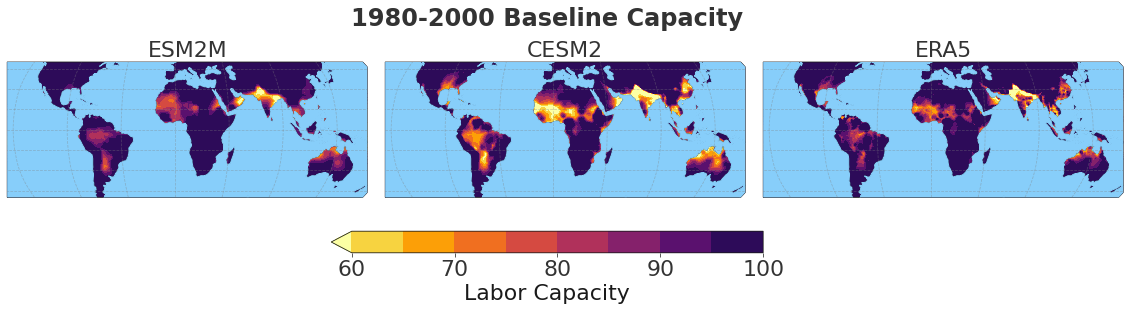

In [50]:
crs = ccrs.Robinson()

fig,ax=plt.subplots(ncols=3,figsize=(20,4),subplot_kw={'projection':crs})
levels = np.arange(60,105,5)

cmap = cm.get_cmap('inferno_r')
colors= cmap(np.arange(0,0.95,0.95/9))

im = lf.contour(ds_base_esm2m,'ESM2M',ax[0],levels=levels,cmap=None,colors=colors,over=None,crop=True,extend='min')
lf.grid(ax[0])
lf.contour(ds_base_cesm2,'CESM2',ax[1],levels=levels,cmap=None,colors=colors,over=None,crop=True,extend='min')
lf.grid(ax[1])
lf.contour(ds_base_era,'ERA5',ax[2],levels=levels,cmap=None,colors=colors,over=None,crop=True,extend='min')
lf.grid(ax[2])

# Single colorbar for all plots
fig.subplots_adjust(bottom=0.225)
cbar_ax = fig.add_axes([0.35, 0.125, 0.3, 0.075])
cbar = fig.colorbar(im, cax=cbar_ax,orientation='horizontal');
cbar.set_label('Labor Capacity',fontsize=22)
cbar.set_ticks(np.arange(60,110,10))
fig.subplots_adjust(wspace=.05,hspace=.05)
fig.suptitle('1980-2000 Baseline Capacity',fontweight='bold')

In [25]:
# Open baseline stdev data
base_sd_esm2m = xr.open_dataarray('../data/processed/GFDL/esm2m_base_sd_hottestmonths.nc').mean('ensemble')
base_sd_cesm2 = xr.open_dataarray('../data/processed/CESM2/cesm2_base_sd_hottestmonths.nc').mean('ensemble')
base_sd_era = xr.open_dataarray('../data/processed/era_base_sd_hottestmonths.nc')

Text(0.5, 0.98, '1980-2000 Baseline Standard Deviation')

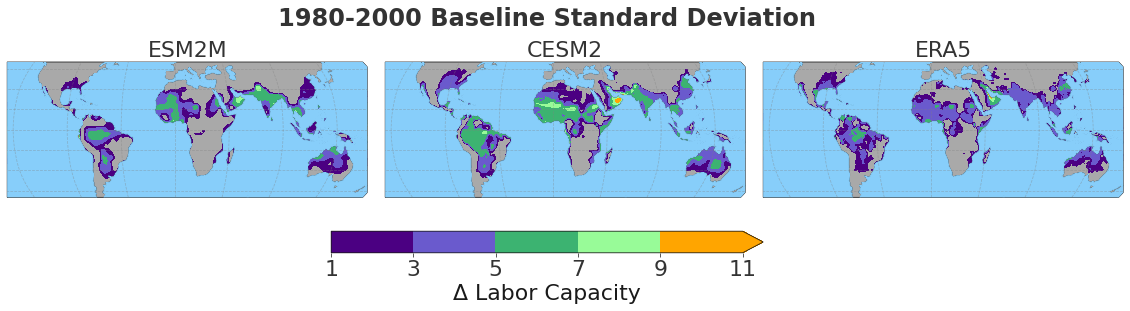

In [53]:
crs = ccrs.Robinson()

fig,ax=plt.subplots(ncols=3,figsize=(20,4),subplot_kw={'projection':crs})
levels = [1,3,5,7,9,11]
colors=['indigo','slateblue','mediumseagreen','palegreen','orange']

im = lf.contour(base_sd_esm2m,'ESM2M',ax[0],levels=levels,cmap=None,colors=colors,over=None,under='darkgray',crop=True)
lf.grid(ax[0])

levels = [0,1,3,5,7,9,11]
colors=['darkgray','indigo','slateblue','mediumseagreen','palegreen','orange']
lf.contour(base_sd_cesm2,'CESM2',ax[1],levels=levels,cmap=None,colors=colors,over=None,under='darkgray',crop=True)
lf.grid(ax[1])
lf.contour(base_sd_era,'ERA5',ax[2],levels=levels,cmap=None,colors=colors,over=None,under='darkgray',crop=True)
lf.grid(ax[2])

# Single colorbar for all plots
fig.subplots_adjust(bottom=0.225)
cbar_ax = fig.add_axes([0.35, 0.125, 0.3, 0.075])
cbar = fig.colorbar(im, cax=cbar_ax,orientation='horizontal',extendfrac=[0,0.05]);
cbar.set_label('Δ Labor Capacity',fontsize=22)
fig.subplots_adjust(wspace=.05,hspace=.05)
fig.suptitle('1980-2000 Baseline Standard Deviation',fontweight='bold')

# Calculate ESM2M Baseline + SD

In [14]:
# Load ESM2M labor capacity data
ds_esm2m = xr.open_mfdataset('../data/processed/GFDL/Monthly_Capacity/monthly_capacity_ens*_1950-2100.nc',combine='nested',concat_dim='ensemble',chunks={'time':1095})
ds_esm2m = ds_esm2m.rename({'__xarray_dataarray_variable__':'capacity'})

In [ ]:
# Calculate 1980-2000 baseline by month
with ProgressBar():
    ds_base_esm2m = lf.calc_baseline(ds_esm2m).compute()

In [15]:
# Slice 1980-2000 data
ds = ds_esm2m
ds_hist  = ds.sel(time=slice('1980-01-31','1999-12-31'))

# Calculate mean and stdev
ds_hist = xr.apply_ufunc(lf.max_avg,ds_hist['capacity'],input_core_dims=[['time']],output_core_dims=[['year']],exclude_dims=set(('time',)),vectorize=True,dask='allowed')
ds_hist_dev = ds_hist.std('year')

In [18]:
# Save baseline SD
ds_hist_dev.to_netcdf('../data/processed/GFDL/esm2m_base_sd_hottestmonths.nc')

# Calculate CESM2 Baseline + SD

In [19]:
# Load ESM2M labor capacity data
ds_cesm2 = xr.open_mfdataset('../data/processed/CESM2/Monthly_Capacity/*',combine='nested',concat_dim='ensemble',chunks={'time':1000}).rename({'__xarray_dataarray_variable__':'capacity'})

In [11]:
# Calculate 1980-2000 baseline by month
with ProgressBar():
    ds_base_cesm2 = lf.calc_baseline(ds_cesm2).compute()

[########################################] | 100% Completed |  3min 32.7s


In [13]:
ds_base_cesm2.to_netcdf('../data/processed/CESM2/cesm2_baseline_hottestmonths.nc')

In [20]:
# Slice 1980-2000 data
ds = ds_cesm2
ds_hist  = ds.sel(time=slice('1980-01-31','1999-12-31'))

# Calculate mean and stdev
ds_hist = xr.apply_ufunc(lf.max_avg,ds_hist['capacity'],input_core_dims=[['time']],output_core_dims=[['year']],exclude_dims=set(('time',)),vectorize=True,dask='allowed')
ds_hist_dev = ds_hist.std('year')

In [22]:
# Save baseline SD
ds_hist_dev.to_netcdf('../data/processed/CESM2/cesm2_base_sd_hottestmonths.nc')

# Calculate ERA Baseline + SD

In [3]:
# Open data
era_wbgt = xr.open_mfdataset('/local/ss23/ERA5/era5_daily_mean_WBGT*',concat_dim='time',combine='by_coords')
# Account for bounds of WBGT-capacity function
era_wbgt = era_wbgt.where(era_wbgt>25,25)
era_wbgt = era_wbgt.where(era_wbgt<33,33)

In [4]:
# Convert from WBGT to capacity
era_cap_daily = 100 - 25*((era_wbgt-25)**(2/3))

# Go from daily capacity to monthly capacity
era_cap_monthly = era_cap_daily.resample(time='1M').mean()
# Rename variables
era_cap_monthly = era_cap_monthly.rename({'WBGT':'capacity','longitude':'lon','latitude':'lat'})

In [5]:
# Calculate 1980-2000 baseline by month
with ProgressBar():
    # Slice 1980-2000 data
    ds = era_cap_monthly
    ds_hist  = ds.sel(time=slice('1980-01-31','1999-12-31'))

    # Calculate mean and stdev
    ds_hist = xr.apply_ufunc(lf.max_avg,ds_hist['capacity'],input_core_dims=[['time']],output_core_dims=[['year']],exclude_dims=set(('time',)),vectorize=True,dask='allowed')
    ds_hist_mean = ds_hist.mean('year')
    ds_hist_dev = ds_hist.std('year')

    # Return baseline as the lower bound of "envelope" around mean 
    ds_base = ds_hist_mean - 2*ds_hist_dev

[########################################] | 100% Completed |  3.6s


In [6]:
# Save baseline mean
ds_base.to_netcdf('../data/processed/era_baseline_hottestmonths.nc')

In [13]:
# Save baseline SD
ds_hist_dev.to_netcdf('../data/processed/era_base_sd_hottestmonths.nc')